In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import splitfolders

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import pickle
import datetime

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,BatchNormalization,GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.models import load_model

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/CS331-BÁO CÁO"
TRAIN_PATH = os.path.join(ROOT_DIR, 'flowers_splited/train')
TEST_PATH = os.path.join(ROOT_DIR, 'flowers_splited/test')

In [ ]:
# splitfolders.ratio(DATASET_PATH,output=os.path.join(ROOT_DIR, 'flowers_splited'),seed=42,ratio=(.9, .1))

# Image Data Generators

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
target_size = (img_height, img_width)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        color_mode='rgb',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', 
    color_mode='rgb',
    subset='validation') 


test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        color_mode='rgb',
        shuffle=False)

Found 3107 images belonging to 5 classes.
Found 775 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [ ]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
class_weights

{0: 1.3763636363636365,
 1: 1.0,
 2: 1.3421985815602837,
 3: 1.433712121212121,
 4: 1.0692090395480225}

In [ ]:
print(train_generator.class_indices)
print(counter)
print(class_weights)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Counter({1: 757, 4: 708, 2: 564, 0: 550, 3: 528})
{0: 1.3763636363636365, 1: 1.0, 2: 1.3421985815602837, 3: 1.433712121212121, 4: 1.0692090395480225}


# Create Model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB2

In [ ]:
base_model = EfficientNetB2(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))



for i, layer in enumerate(base_model.layers):
    print(i, layer.name, "-", layer.trainable)

31790344/31790344 [==============================] - 0s 0us/step
0 input_1 - True
1 rescaling - True
2 normalization - True
3 tf.math.truediv - True
4 stem_conv_pad - True
5 stem_conv - True
6 stem_bn - True
7 stem_activation - True
8 block1a_dwconv - True
9 block1a_bn - True
10 block1a_activation - True
11 block1a_se_squeeze - True
12 block1a_se_reshape - True
13 block1a_se_reduce - True
14 block1a_se_expand - True
15 block1a_se_excite - True
16 block1a_project_conv - True
17 block1a_project_bn - True
18 block1b_dwconv - True
19 block1b_bn - True
20 block1b_activation - True
21 block1b_se_squeeze - True
22 block1b_se_reshape - True
23 block1b_se_reduce - True
24 block1b_se_expand - True
25 block1b_se_excite - True
26 block1b_project_conv - True
27 block1b_project_bn - True
28 block1b_drop - True
29 block1b_add - True
30 block2a_expand_conv - True
31 block2a_expand_bn - True
32 block2a_expand_activation - True
33 block2a_dwconv_pad - True
34 block2a_dwconv - True
35 block2a_bn - True
3

In [ ]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

# Callbacks

In [ ]:
patience = 2
stop_patience = 3
factor = 0.5
callbacks = [
    ModelCheckpoint(os.path.join(ROOT_DIR, 'weights_model/EFF2.h5'), save_best_only=True, save_weights_only=True, verbose=1),
    # EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=factor, patience=patience, verbose=1,min_lr=1e-6)
]

# Model Training

In [ ]:
epochs = 50
print(datetime.datetime.now())
history = model.fit(train_generator, validation_data=validation_generator, class_weight=class_weights, epochs=epochs, callbacks=callbacks, verbose=1)
print(datetime.datetime.now())

2022-10-31 00:55:12.754827
Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 0.7890 - accuracy: 0.7766 
Epoch 1: val_loss improved from inf to 1.68811, saving model to /content/drive/MyDrive/CS331-BÁO CÁO/model/EFF2.h5
98/98 [==============================] - 2496s 25s/step - loss: 0.7890 - accuracy: 0.7766 - val_loss: 1.6881 - val_accuracy: 0.2439 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.9044
Epoch 2: val_loss improved from 1.68811 to 1.57130, saving model to /content/drive/MyDrive/CS331-BÁO CÁO/model/EFF2.h5
98/98 [==============================] - 74s 753ms/step - loss: 0.3530 - accuracy: 0.9044 - val_loss: 1.5713 - val_accuracy: 0.3884 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.9118
Epoch 3: val_loss did not improve from 1.57130
98/98 [==============================] - 73s 746ms/step - loss: 0.3219 - accuracy: 0.9118 - val_loss: 1.7444 - val_

In [ ]:
#with open(os.path.join(ROOT_DIR, 'history_dict_effb2.pkl'), 'wb') as file_pi:
    #pickle.dump(history.history, file_pi)

In [ ]:
#model.evaluate(test_generator)

14/14 [==============================] - 314s 24s/step - loss: 0.1603 - accuracy: 0.9494


[0.16027046740055084, 0.9494252800941467]

In [ ]:
pickle_in = open(os.path.join(ROOT_DIR, 'history_dict_effb2.pkl'), "rb")
dict_log = pickle.load(pickle_in)

In [ ]:
dict_log.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

(0.0, 1.0)

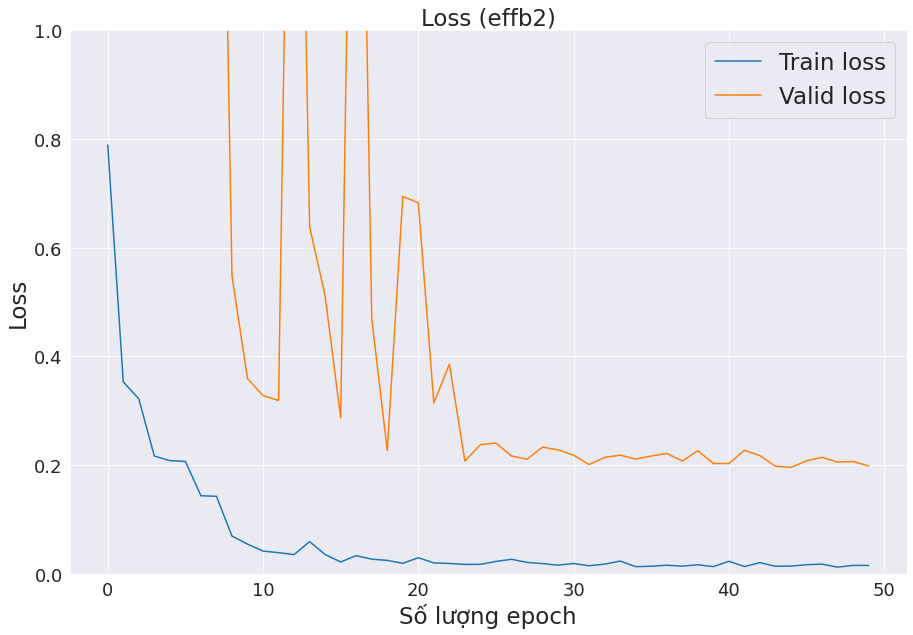

In [ ]:
plt.figure(figsize=(15, 10))
# plt.grid()


plt.plot(dict_log['loss'], label='Train loss')
plt.plot(dict_log['val_loss'], label='Valid loss')
plt.title('Loss (effb2)', fontsize=23)
plt.ylabel('Loss', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")


(0.8, 1.0)

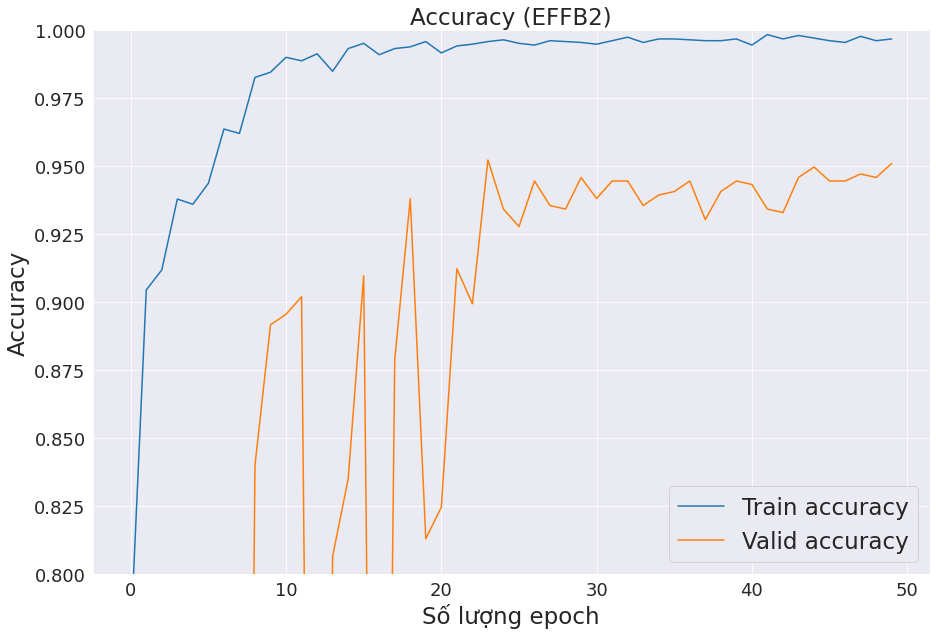

In [ ]:
plt.figure(figsize=(15, 10))
# plt.grid()


plt.plot(dict_log['accuracy'], label='Train accuracy')
plt.plot(dict_log['val_accuracy'], label='Valid accuracy')
plt.title('Accuracy (EFFB2)', fontsize=23)
plt.ylabel('Accuracy', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0.8, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")


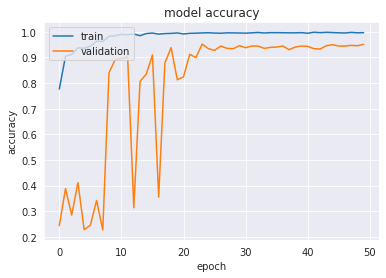

In [ ]:
plt.plot(dict_log['accuracy'])
plt.plot(dict_log['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-2.png")
plt.show()

# Predictions on Test Set

In [ ]:
best_model = model
best_model.load_weights(os.path.join(ROOT_DIR, 'weights_model/EFF2.h5'))

In [ ]:
best_model.evaluate(test_generator)

14/14 [==============================] - 67s 4s/step - loss: 0.1610 - accuracy: 0.9540


[0.1609693169593811, 0.954023003578186]

In [ ]:
preds = best_model.predict(test_generator)

14/14 [==============================] - 4s 146ms/step


In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]

    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir, dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      

    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    

    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
            
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig1=plt.figure()
        fig1.set_figheight(len(plot_class)/3)
        fig1.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        fig2 = plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix (EFFB2)")
        # plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-4.png", dpi = 100)
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

        # fig1.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-3.png", dpi = 100)

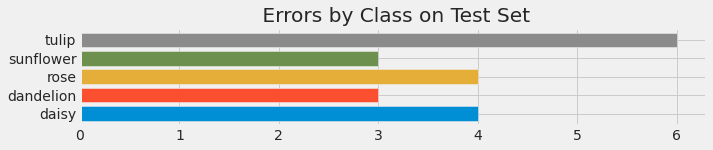

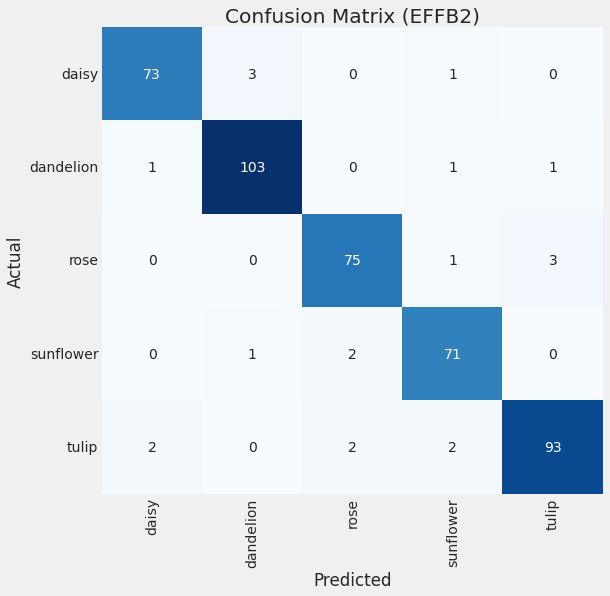

Classification Report:
----------------------
               precision    recall  f1-score   support

       daisy       0.96      0.95      0.95        77
   dandelion       0.96      0.97      0.97       106
        rose       0.95      0.95      0.95        79
   sunflower       0.93      0.96      0.95        74
       tulip       0.96      0.94      0.95        99

    accuracy                           0.95       435
   macro avg       0.95      0.95      0.95       435
weighted avg       0.95      0.95      0.95       435



In [ ]:
save_dir = ''
subject = "kq"
print_code = 0
print_info(test_generator, preds, print_code, save_dir, subject)